<a href="https://colab.research.google.com/github/Bekka29/knbs-breastcancerproject/blob/main/breast_cancer_lesion_uss_project_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Breast cancer Ultrasound Image segmentation using U-Net




In [ ]:
#Mount google drive to enable downloading of dataset
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install torchmetrics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 11.0 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import zipfile
from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
from torch.utils.data import TensorDataset
from torchvision.transforms import ToTensor
# import torchvision.transforms as transforms
# from torchvision.datasets import ImageFolder
# from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torchmetrics.functional import dice
from torch.utils.data import random_split
import cv2 as cv2
from glob import glob
%matplotlib inline

In [ ]:
# Project name used for jovian.commit
project_name = 'breast-cancer-lesions-project-final'

## Pre-processing the Breast Cancer Image dataset



In [ ]:
# Extract dataset from archive
# /content/drive/MyDrive/archive.zip
with zipfile.ZipFile("/content/drive/MyDrive/archive.zip","r") as zip_ref:
    zip_ref.extractall("./data")

In [ ]:
data_dir = './data/Dataset_BUSI_with_GT'

print(os.listdir(data_dir))
classes = os.listdir(data_dir)
print(classes)

['normal', 'benign', 'malignant']
['normal', 'benign', 'malignant']


In [ ]:
normal = os.listdir(data_dir + "/normal")
print('No. of normal samples in dataset:', len(normal))
print(normal[:5])

No. of normal samples in dataset: 266
['normal (84)_mask.png', 'normal (84).png', 'normal (62)_mask.png', 'normal (58).png', 'normal (104)_mask.png']


In [ ]:
benign = os.listdir(data_dir + "/benign")
print('No. of benign samples in dataset:', len(benign))
print(benign[:5])

No. of benign samples in dataset: 891
['benign (303).png', 'benign (371).png', 'benign (68).png', 'benign (101)_mask.png', 'benign (118).png']


In [ ]:
malignant = os.listdir(data_dir + "/malignant")
print('No. of malignant samples in dataset:', len(malignant))
print(malignant[:5])

No. of malignant samples in dataset: 421
['malignant (39).png', 'malignant (126)_mask.png', 'malignant (3)_mask.png', 'malignant (207)_mask.png', 'malignant (185)_mask.png']


In [ ]:
def load_image(path, size):
    image = cv2.imread(path)
    image = cv2.resize(image, (size,size))
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)   # shape: (size,size,3) -> (size,size,1)
    image = image/255.   # normalize
    return image

def load_data(root_path, size):
    images = []
    masks = []

    x = 0   # additional variable to identify images consisting of 2 or more masks

    for path in sorted(glob(root_path)):
        img = load_image(path, size)   # read mask or image

        if 'mask' in path:
            if x:   # this image has masks more than one
                masks[-1] += img   # add the mask to the last mask

                # When 2 masks are added, the range can increase by 0-2. So we will reduce it again to the range 0-1.
                masks[-1] = np.array(masks[-1]>0.5, dtype='float64')
            else:
                masks.append(img)
                x = 1   # if the image has a mask again, the above code will run next time
        else:
            images.append(img)
            x = 0   # for moving to the next image
    return np.array(images), np.array(masks)

In [ ]:
size = 128   # image size: 128x128
X, y = load_data(data_dir+'/*/*', size)

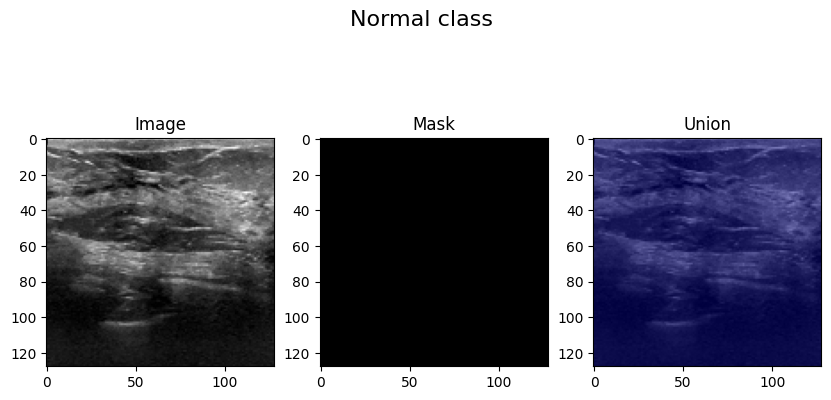

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))


i = np.random.randint(647,780)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(y[i], alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Normal class', fontsize=16)
plt.show()

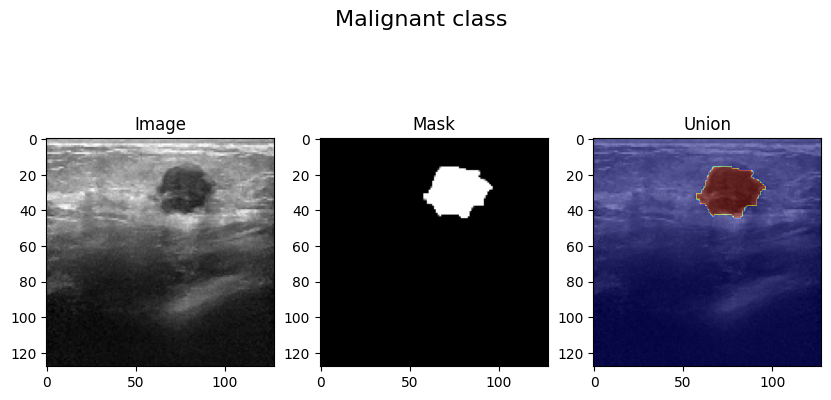

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

i = np.random.randint(437,647)
ax[0].imshow(X[i], cmap='gray')
ax[0].set_title('Image')
ax[1].imshow(y[i], cmap='gray')
ax[1].set_title('Mask')
ax[2].imshow(X[i], cmap='gray')
ax[2].imshow(y[i], alpha=0.5, cmap='jet')
ax[2].set_title('Union')
fig.suptitle('Malignant class', fontsize=16)
plt.show()

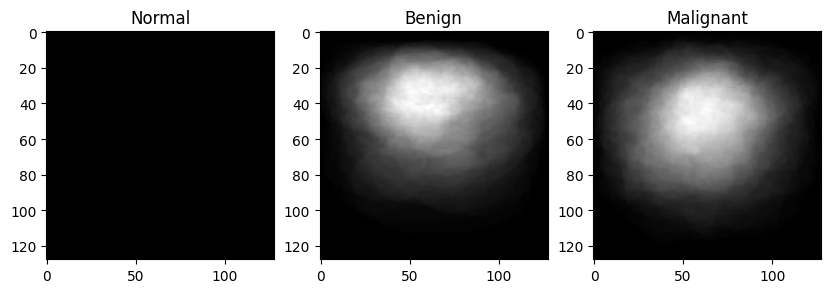

In [ ]:
fig, ax = plt.subplots(1,3, figsize=(10,5))

ax[0].imshow(sum(y[647:]), cmap='gray')
ax[0].set_title('Normal')
ax[1].imshow(sum(y[:437]), cmap='gray')
ax[1].set_title('Benign')
ax[2].imshow(sum(y[437:647]), cmap='gray')
ax[2].set_title('Malignant')
plt.show()

In [ ]:
#shape of dataset
print(X.shape)
print(y.shape)

(780, 128, 128)
(780, 128, 128)


In [ ]:
# expand the dimension of the array for use in pytorch
X = np.expand_dims(X, axis = 1)
y = np.expand_dims(y, axis =1)

In [ ]:
print(X.shape)
print(y.shape)

(780, 1, 128, 128)
(780, 1, 128, 128)


In [ ]:
# we only use benign and malignant data for training and they are located at index 647 and above
X = X[:647]
y = y[:647]

In [ ]:
X = torch.Tensor(X)
y = torch.Tensor(y)

In [ ]:
dataset = TensorDataset(X,y) # create your tensor dataset

In [ ]:
img, label = dataset[0]
print(img.shape, label.shape)

torch.Size([1, 128, 128]) torch.Size([1, 128, 128])


In [ ]:
dataset_size = len(dataset)
dataset_size

647

## Preparing the data for training

Using a validation set with 65 images (10% of the dataset without normal class) and test set with 195 images (30% of the dataset) . To ensure we get the same validation set each time, set PyTorch's random number generator to a seed value of 32.

In [ ]:
torch.manual_seed(32)
val_size = 65
test_size = 195
train_size = len(dataset) - (val_size + test_size)

In [ ]:
train_ds, val_ds, test_ds = random_split(dataset, [train_size, val_size, test_size])
len(train_ds), len(val_ds), len(test_ds)

(387, 65, 195)

Creating data loaders to load the data in batches.

In [ ]:
batch_size=4

In [ ]:
train_loader = DataLoader(train_ds, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size*2, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size*2, num_workers=2, pin_memory=True)

In [ ]:
#to show batch shape of training loader
iterator=iter(train_loader)
d= next(iterator)
print(d[0].shape)

torch.Size([4, 1, 128, 128])


## Training on GPU



In [ ]:
torch.cuda.is_available()

True

In [ ]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
def accuracy(outputs, labels):
    return dice(outputs.type(torch.int64), labels.type(torch.int64), average='micro')

In [ ]:
def plot_losses(history):
    losses = [x['val_loss'] for x in history]
    plt.plot(losses, '-x')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Loss vs. No. of epochs');

In [ ]:
def plot_accuracies(history):
    accuracies = [x['val_acc'] for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

In [ ]:
train_loader = DeviceDataLoader(train_loader, device)
val_loader = DeviceDataLoader(val_loader, device)
test_loader = DeviceDataLoader(test_loader, device)

## Training the model



In [ ]:
#convolution block
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()

    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

# encoder
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))

    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p


#decoder
class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)

    def forward(self, inputs, skip):
        x = self.up(inputs)
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x



In [ ]:
#unet architecture
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64)
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)

    def forward(self, inputs):
        """ Encoder """
        s1, p1 = self.e1(inputs)
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)

        return F.sigmoid(outputs)

    #MODIFICATIONS TO EXTEND THE U NET MODELTO PROVIDE STATISTICS
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate predictions
        loss = F.binary_cross_entropy(out, labels) # Calculate loss
        return loss

    def validation_step(self, batch):
        images, labels = batch
        out = self(images)                    # Generate predictions
        loss = F.binary_cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc.detach()}

    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))



In [ ]:
def evaluate(model, val_loader):
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.Adam):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

Model instantiation

In [ ]:
model = to_device(build_unet(), device)


In [ ]:
history = [evaluate(model, val_loader)]
history

[{'val_loss': 0.8402033448219299, 'val_acc': 0.8959324955940247}]

In [ ]:
epochs=100
lr=1e-4
history += fit(epochs, lr, model, train_loader, val_loader)

Epoch [0], val_loss: 0.4308, val_acc: 0.8963
Epoch [1], val_loss: 0.3863, val_acc: 0.8965
Epoch [2], val_loss: 0.3471, val_acc: 0.8962
Epoch [3], val_loss: 0.3215, val_acc: 0.8962
Epoch [4], val_loss: 0.2875, val_acc: 0.8959
Epoch [5], val_loss: 0.2650, val_acc: 0.8961
Epoch [6], val_loss: 0.2390, val_acc: 0.8960
Epoch [7], val_loss: 0.2280, val_acc: 0.8961
Epoch [8], val_loss: 0.2112, val_acc: 0.8961
Epoch [9], val_loss: 0.2104, val_acc: 0.8961
Epoch [10], val_loss: 0.1954, val_acc: 0.8960
Epoch [11], val_loss: 0.1867, val_acc: 0.8960
Epoch [12], val_loss: 0.1833, val_acc: 0.8960
Epoch [13], val_loss: 0.1747, val_acc: 0.8962
Epoch [14], val_loss: 0.1938, val_acc: 0.8960
Epoch [15], val_loss: 0.1605, val_acc: 0.8960
Epoch [16], val_loss: 0.1632, val_acc: 0.8961
Epoch [17], val_loss: 0.1861, val_acc: 0.8962
Epoch [18], val_loss: 0.1462, val_acc: 0.8961
Epoch [19], val_loss: 0.1627, val_acc: 0.8960
Epoch [20], val_loss: 0.1461, val_acc: 0.8965
Epoch [21], val_loss: 0.1491, val_acc: 0.896

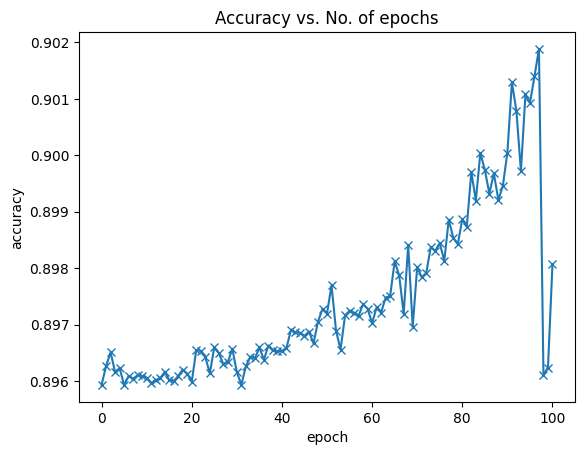

In [ ]:
plot_accuracies(history)

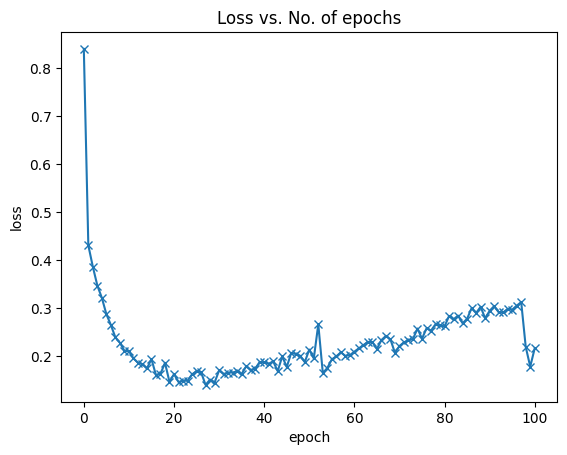

In [ ]:
plot_losses(history)

In [ ]:
evaluate(model, test_loader)

{'val_loss': 0.2022484391927719, 'val_acc': 0.910296618938446}

In [ ]:
iter_test = iter(test_loader)

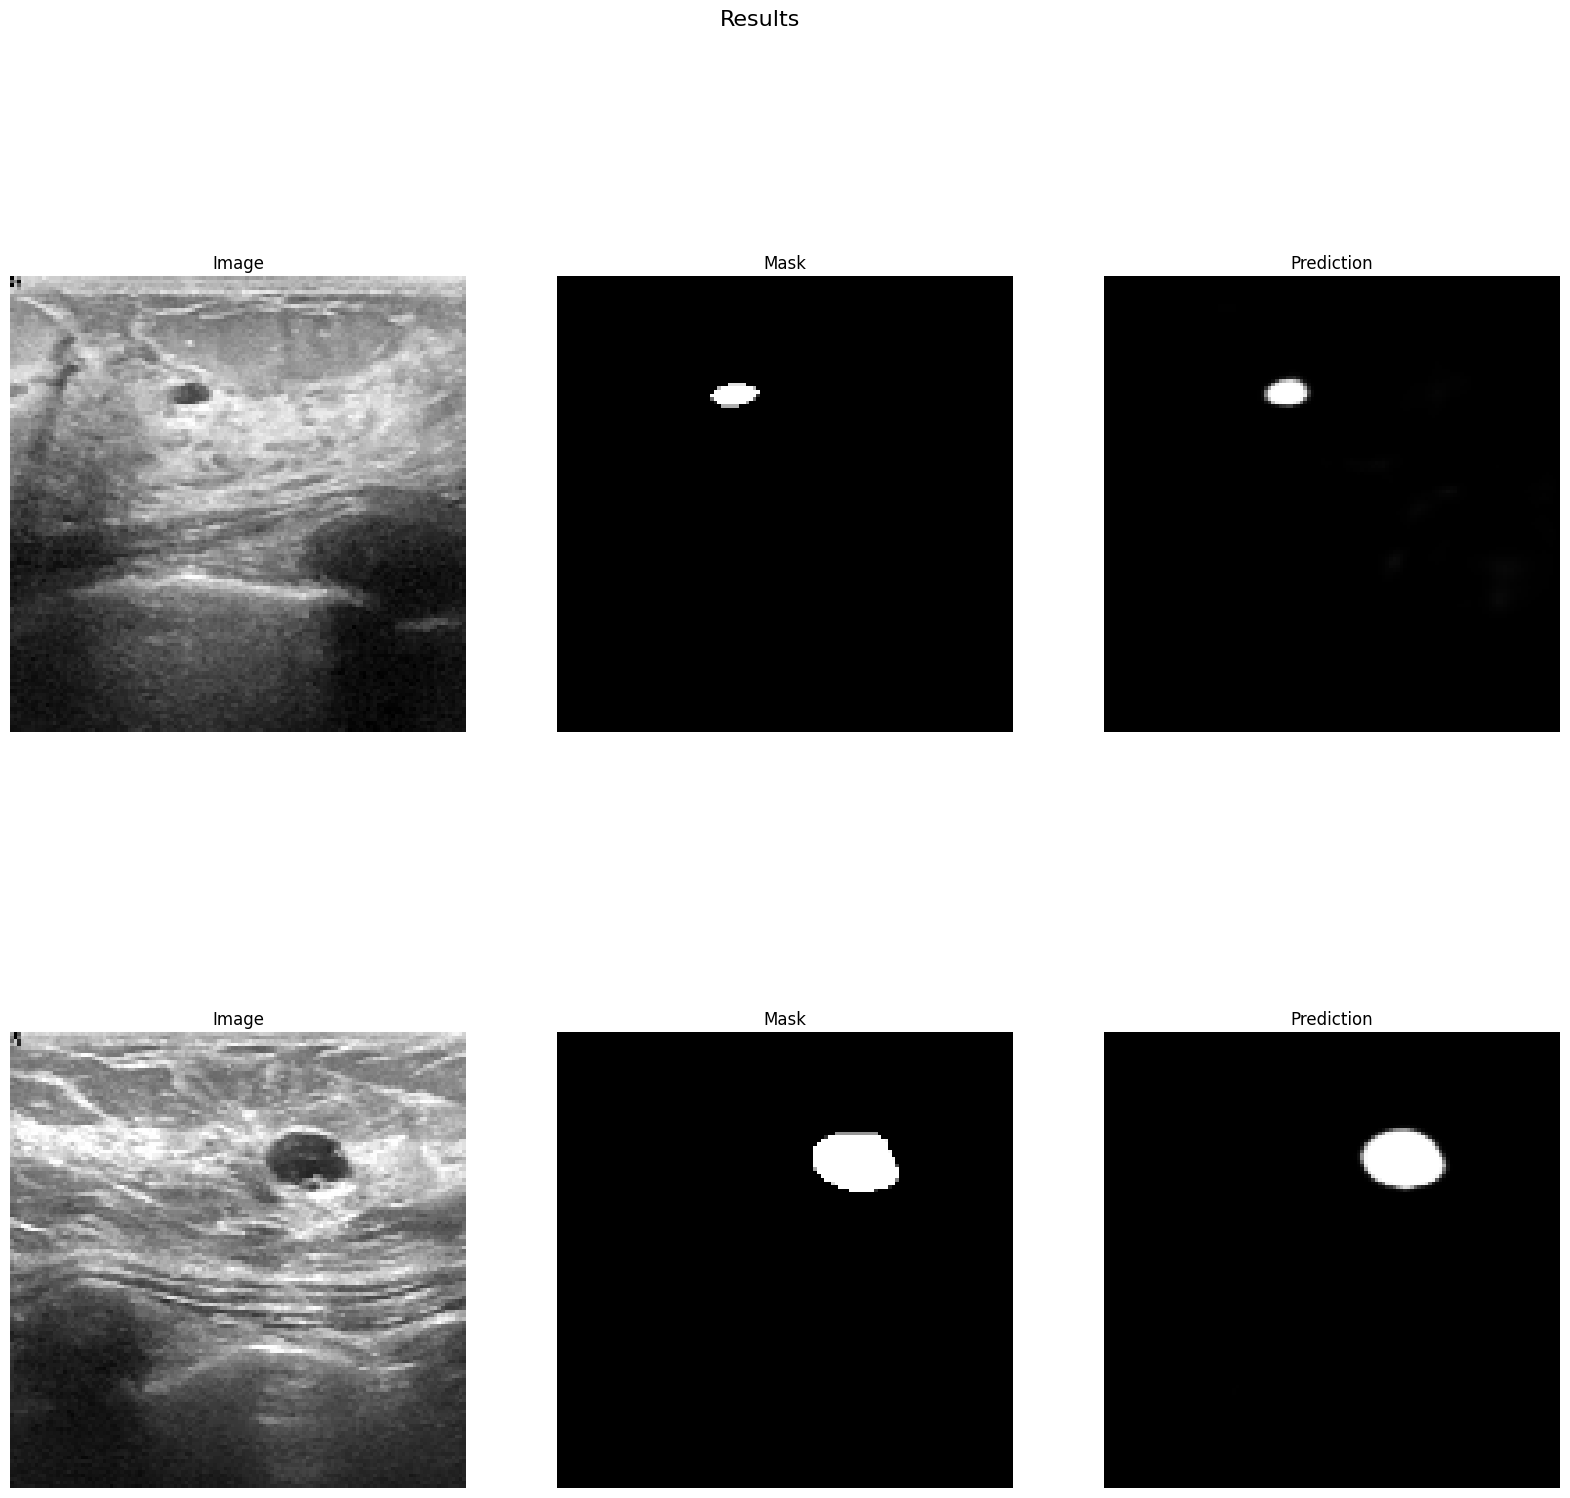

In [ ]:
test_data = next(iter_test)

num_images = len(test_data)
fig, ax = plt.subplots(num_images,3, figsize=(20,18))
pred = model(test_data[0])
for i in range(num_images):
    ax[i,0].imshow(test_data[0][i, 0].cpu().numpy(), cmap='gray')
    ax[i,0].set_title('Image')
    ax[i,0].axis('off')

    ax[i,1].imshow(test_data[1][i, 0].cpu().numpy(), cmap='gray')
    ax[i,1].set_title('Mask')
    ax[i,1].axis('off')

    ax[i,2].imshow(pred[i, 0].detach().cpu().numpy(), cmap='gray')
    ax[i,2].set_title('Prediction')
    ax[i,2].axis('off')
fig.suptitle('Results', fontsize=16)
plt.show()

**REFERENCES**

1.Bhowmik A, Eskreis-Winkler S. Deep learning in breast imaging. BJR Open. 2022 May 13;4(1):20210060. doi: 10.1259/bjro.20210060. PMID: 36105427; PMCID: PMC9459862.

2.Arnold M, Morgan E, Rumgay H, Mafra A, Singh D, Laversanne M, Vignat J, Gralow J R, Cardoso F, Siesling S, Soerjomataram I, Current and future burden of breast cancer: Global statistics for 2020 and 2040, The Breast, Volume 66,2022, Pages 15-23,ISSN 0960-9776, https://doi.org/10.1016/j.breast.2022.08.010.
(https://www.sciencedirect.com/science/article/pii/S0960977622001448)

3.Malhotra P, Gupta S, Koundal D, Zaguia A, Enbeyle W. Deep Neural Networks for Medical Image Segmentation. J Healthc Eng. 2022 Mar 10;2022:9580991. doi: 10.1155/2022/9580991. PMID: 35310182; PMCID: PMC8930223.

4.Ronneberger, O., Fischer, P., Brox, T. (2015). U-Net: Convolutional Networks for Biomedical Image Segmentation. In: Navab, N., Hornegger, J., Wells, W., Frangi, A. (eds) Medical Image Computing and Computer-Assisted Intervention – MICCAI 2015. MICCAI 2015. Lecture Notes in Computer Science(), vol 9351. Springer, Cham. https://doi.org/10.1007/978-3-319-24574-4_28

5.https://www.kaggle.com/code/saidislombek/biomedical-image-segmentation-with-u-net/notebook

6. Al-Dhabyani W, Gomaa M, Khaled H, Fahmy A. Dataset of breast ultrasound images. Data in Brief. 2020 Feb;28:104863. DOI: 10.1016/j.dib.2019.104863.